# 04. Convolutional Neural Network(CNN)으로 숫자 분류기 구현하기


In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")


PACKAGES LOADED


In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


# Define Model

In [3]:
n_input = 784
n_channel = 64 # Convolution Filter의 개수
n_classes = 10

x = tf.placeholder('float', [None, n_input])
y = tf.placeholder('float', [None, n_classes])

stddev = 0.1
weights = {
    'c1' : tf.Variable(tf.random_normal([3, 3, 1,n_channel], stddev=stddev)), # 매트릭스 형태
    'c2' : tf.Variable(tf.random_normal([3, 3, n_channel, 128], stddev=stddev)),
    'd1' : tf.Variable(tf.random_normal([7*7*128, n_classes], stddev=stddev))
}
biases = {
    'c1' : tf.Variable(tf.random_normal([n_channel], stddev=stddev)),
    'c2' : tf.Variable(tf.random_normal([128], stddev=stddev)),
    'd1' : tf.Variable(tf.random_normal([n_classes], stddev=stddev))
}
print("NETWORK READY")

NETWORK READY


In [4]:
def CNN(_x, _w, _b):
    # RESHAPE
    _x_r = tf.reshape(_x, shape=[-1, 28, 28, 1]) # -1 : 몇인지 모르기 때문, 1: 흑백으로 전환
    # CONVOLUTION
    _conv1 = tf.nn.conv2d(_x_r, _w['c1'], strides=[1, 1, 1, 1], padding='SAME')
    # ADD BIAS
    _conv2 = tf.nn.bias_add(_conv1, _b['c1'])
    # RELU
    _conv3 = tf.nn.relu(_conv2)
    #MAX-POOl
    _pool = tf.nn.max_pool(_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
     # 위에 conv1 conv2 conv3 pool은 외우세요!
        
    # SECOND CONV LAYER
    _temp = tf.nn.conv2d(_pool, _w['c2'], strides=[1, 1, 1, 1], padding='SAME')
    _temp = tf.nn.bias_add(_temp, _b['c2'])
    _temp = tf.nn.relu(_temp)
    _temp = tf.nn.max_pool(_temp, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # VECTORIZE
    _dense = tf.reshape(_temp, [-1, _w['d1'].get_shape().as_list()[0]])
    # DENSE
    _logit = tf.add(tf.matmul(_dense, _w['d1']), _b['d1'])
    _out = {
        'x_r' : _x_r, 'conv1' : _conv1, 'conv2' : _conv2, 'conv3' : _conv3,
        'pool' : _pool, 'dense' : _dense, 'logit' : _logit
    }
    return _out

# PREDICTION
cnnout = CNN(x, weights, biases)

# LOSS AND OPTIMZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=cnnout['logit']))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
corr = tf.equal(tf.argmax(cnnout['logit'], 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTION READY")

FUNCTION READY


- edwith에 나와있는 코드엔 오타들이 존재합니다 
    - pool = tf.max_pool -> tf.nn.max_pool
    - _dense = tf.reshape(_temp. [-1, _w['d1'].get_shape().as_list()[0]])에서 _temp. -> _temp,
    - 'conv2' = conv2 -> 'conv2' : _conv2
    - logit' : _logit' -> _logit (' 제거)
    - return의 위치
- 또한 Saver에 대한 정의가 없어 오류가 났었습니다

# Saver

In [ ]:
savedir = "nets/"
saver = tf.train.Saver(max_to_keep=3) 
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("Saver Ready!")

# RUN

In [5]:
# PARAMETERS
training_epochs = 20
batch_size = 100
display_step = 4

In [6]:
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)

In [19]:
# OPTIMIZER
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

    # Display logs per epoch step
    if epoch % display_step == 0: 
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys}
        train_acc = sess.run(accr, feed_dict=feeds) 
        print (" Training accuracy: %.3f" % (train_acc))
        feeds = {x: mnist.test.images[:100, :], y:mnist.test.labels[:100, :]} # 100개만 가지고 test
        test_acc = sess.run(accr, feed_dict=feeds)
        print (" Test accuracy: %.3f" % (test_acc))

    # Save Net
    if (epoch+1) % save_step == 0:
        savename = savedir+"net-"+str(epoch+1)+".ckpt"
        saver.save(sess. savename)
        print ("[%s] SAVED" % (savename))
print ("Optimization Finished.")

In [20]:
do_restore = 1
if do_restore ==1:
    sess = tf.Session()
    epoch = 2
    savename = savedir +"net-"+str(epoch)+".cpkt"
    saver.restore(sess, savename)
    print("Network RESTORED")
else:
    print("Do Nothing")

In [ ]:
# 중간 중간 단계를 다 볼 수 있음!

In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [7]:
input_r = sess.run(cnnout['x_r'], feed_dict={x: trainimg[0:1, :]})
conv1 = sess.run(cnnout['conv1'], feed_dict={x: trainimg[0:1, :]})
conv2 = sess.run(cnnout['conv2'], feed_dict={x: trainimg[0:1, :]})
conv3 = sess.run(cnnout['conv3'], feed_dict={x: trainimg[0:1, :]})
pool = sess.run(cnnout['pool'], feed_dict={x: trainimg[0:1, :]})
dense = sess.run(cnnout['dense'], feed_dict={x: trainimg[0:1, :]})
out = sess.run(cnnout['logit'], feed_dict={x: trainimg[0:1, :]})

Size of 'input_r' is (1, 28, 28, 1)
Label is 7


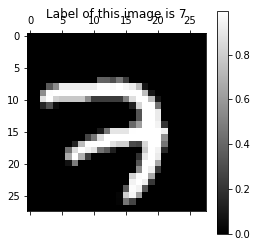

In [8]:
# Let's see 'input_r'
print ("Size of 'input_r' is %s" % (input_r.shape,))
label = np.argmax(trainlabel[0, :])
print ("Label is %d" % (label))

# Plot ! 
plt.matshow(input_r[0, :, :, 0], cmap=plt.get_cmap('gray'))
plt.title("Label of this image is " + str(label) + "")
plt.colorbar()
plt.show()

# conv1

Size of 'conv1' is (1, 28, 28, 64)


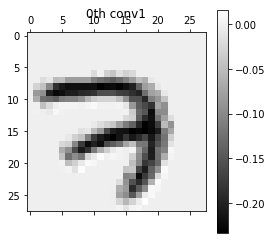

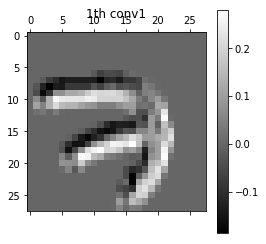

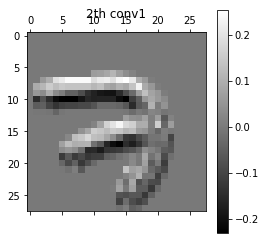

In [9]:
# Let's see 'conv1'
print ("Size of 'conv1' is %s" % (conv1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv1[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv1")
    plt.colorbar()
    plt.show()

# conv2 + bias

Size of 'conv2' is (1, 28, 28, 64)


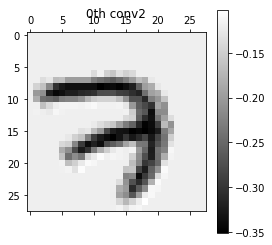

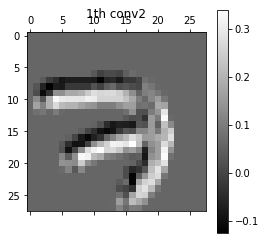

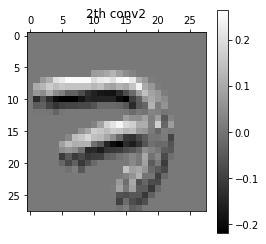

In [10]:
# Let's see 'conv2'
print ("Size of 'conv2' is %s" % (conv2.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv2[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv2")
    plt.colorbar()
    plt.show()

# Conv3 (ReLU)

Size of 'conv3' is (1, 28, 28, 64)


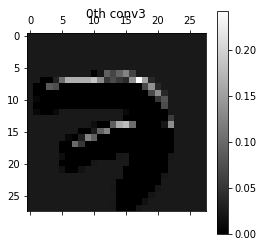

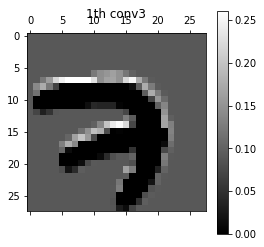

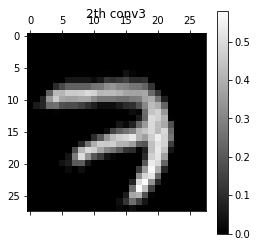

In [41]:
# Let's see 'conv3'
print ("Size of 'conv3' is %s" % (conv3.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(conv3[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv3")
    plt.colorbar()
    plt.show()

    # bias가 너무 작으면 모든 값이 0으로 줄어듬 -> activation 함수를 통하면 0으로 되고 학습이 안됨
    # Dead Node, Dead Relu 현상

# Pool (max_pool)

Size of 'pool' is (1, 14, 14, 64)


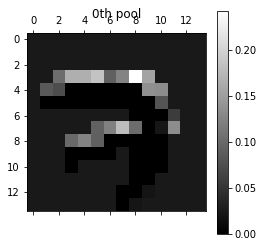

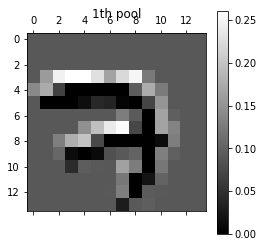

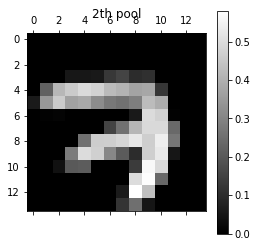

In [42]:
# Let's see 'pool'
print ("Size of 'pool' is %s" % (pool.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(pool[0, :, :, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th pool")
    plt.colorbar()
    plt.show()

# Dense

Size of 'dense' is (1, 6272)
Size of 'out' is (1, 10)


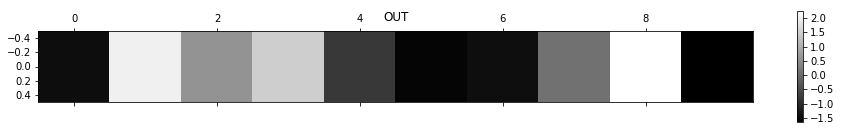

In [11]:
# Let's see 'dense'
print ("Size of 'dense' is %s" % (dense.shape,))
# Let's see 'out'
print ("Size of 'out' is %s" % (out.shape,))
plt.matshow(out, cmap=plt.get_cmap('gray'))
plt.title("OUT")
plt.colorbar()
plt.show()

# Convolution filters

Size of 'wc1' is (3, 3, 1, 64)


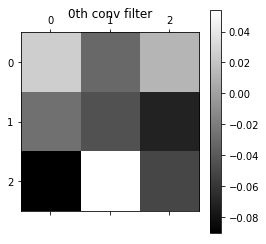

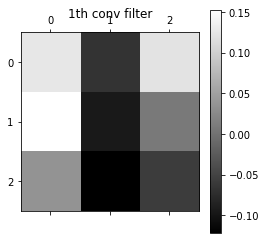

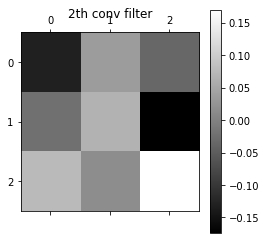

In [12]:
# Let's see weight! 
wc1 = sess.run(weights['c1'])
print ("Size of 'wc1' is %s" % (wc1.shape,))

# Plot ! 
for i in range(3):
    plt.matshow(wc1[:, :, 0, i], cmap=plt.get_cmap('gray'))
    plt.title(str(i) + "th conv filter")
    plt.colorbar()
    plt.show()